# Harmony EOSS L2SS API Tutorial

## Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT environment, which 
will be used for this notebook by visiting [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov).
These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [1]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


Now call the above function to set up Earthdata Login for subsequent requests

In [2]:
setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

### Find a granule for subsetting

Below we call out a specific granule (G1226018995-POCUMULUS) on which we will use the podaac L2 subsetter. Finding this information would complicate the tutorial- but po.daac has a tutorial available for using the CMR API to find collections and granules of interest. Please see the following tutorial for that information:

PODAAC_CMR.ipynb


In [3]:
collection = 'C1234208438-POCLOUD'

##  Subset of a PO.DAAC Granule

We can now build onto the root URL in order to actually perform a transformation.  The first transformation is a subset of a selected granule.  _At this time, this requires discovering the granule id from CMR_.  That information can then be appended to the root URL and used to call Harmony with the help of the `request` library.

Above we show how to find a granule id for processing.

**Notes:**
  The L2 subsetter current streams the data back to the user, and does not stage data in S3 for redirects. This is functionality we will be adding over time.
  It doesn't work with URS backed files, which is coming in the next few weeks
  it only works on the show dataset, but 
    

In [4]:
import requests
cmr_url = "https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id="+collection+"&bounding_box=-90,-45.75,90,-45"
response = requests.get(cmr_url)

gid=response.json()['items'][0]['meta']['concept-id']
print(response.json()['items'][0])
print(gid)




{'meta': {'concept-type': 'granule', 'concept-id': 'G1234413347-POCLOUD', 'revision-id': 5, 'native-id': 'JA1_GPS_2PeP001_002_20020115_060706_20020115_070316', 'provider-id': 'POCLOUD', 'format': 'application/vnd.nasa.cmr.umm+json', 'revision-date': '2020-04-13T07:58:05Z'}, 'umm': {'RelatedUrls': [{'URL': 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/JA1_GPS_2PeP001_002_20020115_060706_20020115_070316.nc', 'Type': 'GET DATA', 'Description': 'The base directory location for the granule.'}, {'URL': 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-public/JA1_GPS_2PeP001_002_20020115_060706_20020115_070316.cmr.json', 'Type': 'EXTENDED METADATA', 'Description': 'File to download'}, {'URL': 'https://archive.podaac.uat.earthdata.nasa.gov/s3credentials', 'Type': 'VIEW RELATED INFORMATION', 'Description': 'api endpoint to retrieve temporary credentials valid for same-region direct s3 access'}], 'SpatialExtent': {'HorizontalSpatialDomain': {'Geometr

In [7]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
bboxSubsetConfig = {
    'collection_id': collection,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': gid,
    'lat': '(-45.75:45)',
    'lon': '(-90:90)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


Request URL https://harmony.uat.earthdata.nasa.gov/C1234208438-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234413347-POCLOUD&subset=lat(-45.75:45)&subset=lon(-90:90)


In [8]:
import shutil
with request.urlopen(bbox_url) as response, open('ogc_temp.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp.nc")

Content Size: 7228503
Downloaded request to ogc_temp.nc


In [9]:
import xarray as xa
ds = xa.open_dataset('ogc_temp.nc')
ds

<xarray.Dataset>
Dimensions:                             (meas_ind: 20, time: 661, wvf_ind: 104)
Coordinates:
    lat                                 (time) float64 ...
    lon                                 (time) float64 ...
    lon_20hz                            (time, meas_ind) float64 ...
    lat_20hz                            (time, meas_ind) float64 ...
  * time                                (time) datetime64[ns] 2002-01-15T06:39:10.318289992 ... 2002-01-15T06:51:12.502629040
  * meas_ind                            (meas_ind) int8 0 1 2 3 ... 16 17 18 19
  * wvf_ind                             (wvf_ind) int8 0 1 2 3 ... 101 102 103
Data variables:
    time_20hz                           (time, meas_ind) datetime64[ns] ...
    surface_type                        (time) float32 ...
    surface_type_globcover              (time) float32 ...
    alt_echo_type                       (time) float32 ...
    rad_surf_type                       (time) float32 ...
    rad_distance_to_land                (time) float64 ...
    qual_alt_1hz_range_ku               (time) float32 ...
    qual_alt_1hz_range_c                (time) float32 ...
    qual_alt_1hz_swh_ku                 (time) float32 ...
    qual_alt_1hz_swh_c                  (time) float32 ...
    qual_alt_1hz_sig0_ku                (time) float32 ...
    qual_alt_1hz_sig0_c                 (time) float32 ...
    qual_alt_1hz_off_nadir_angle_wf_ku  (time) float32 ...
    qual_inst_corr_1hz_range_ku         (time) float32 ...
    qual_inst_corr_1hz_range_c          (time) float32 ...
    qual_inst_corr_1hz_swh_ku           (time) float32 ...
    qual_inst_corr_1hz_swh_c            (time) float32 ...
    qual_inst_corr_1hz_sig0_ku          (time) float32 ...
    qual_inst_corr_1hz_sig0_c           (time) float32 ...
    qual_rad_1hz_tb187                  (time) float32 ...
    qual_rad_1hz_tb238                  (time) float32 ...
    qual_rad_1hz_tb340                  (time) float32 ...
    rad_averaging_flag                  (time) float32 ...
    rad_land_frac_187                   (time) float32 ...
    rad_land_frac_238                   (time) float32 ...
    rad_land_frac_340                   (time) float32 ...
    alt_state_flag_oper                 (time) float32 ...
    alt_state_flag_c_band               (time) float32 ...
    alt_state_flag_band_seq             (time) float32 ...
    alt_state_flag_ku_band_status       (time) float32 ...
    alt_state_flag_c_band_status        (time) float32 ...
    rad_state_flag_oper                 (time) float32 ...
    orb_state_flag_rest                 (time) float32 ...
    rain_flag                           (time) float32 ...
    rad_rain_flag                       (time) float32 ...
    ice_flag                            (time) float32 ...
    rad_sea_ice_flag                    (time) float32 ...
    interp_flag_tb                      (time) float32 ...
    interp_flag_ocean_tide_sol1         (time) float32 ...
    interp_flag_ocean_tide_sol2         (time) float32 ...
    alt                                 (time) float64 ...
    alt_20hz                            (time, meas_ind) float64 ...
    orb_alt_rate                        (time) float32 ...
    range_ku                            (time) float64 ...
    range_20hz_ku                       (time, meas_ind) float64 ...
    range_c                             (time) float64 ...
    range_20hz_c                        (time, meas_ind) float64 ...
    range_used_20hz_ku                  (time, meas_ind) float32 ...
    range_used_20hz_c                   (time, meas_ind) float32 ...
    range_rms_ku                        (time) float32 ...
    range_rms_c                         (time) float32 ...
    range_numval_ku                     (time) float32 ...
    range_numval_c                      (time) float32 ...
    number_of_iterations_ku             (time, meas_ind) float32 ...
    number_of_iterations_c              (time, meas_ind) float32 ...
 

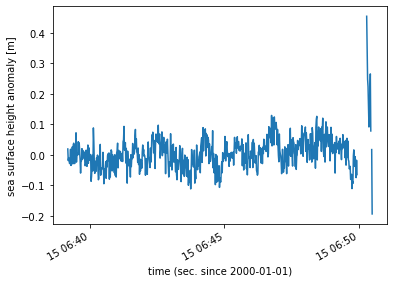

In [11]:
ds.ssha.plot()

## Verify the subsetting worked

Bounds used were: 

  'lat': '(-45.75:45)',
  'lon': '(-90:90)'

In [12]:
lat_max = ds.lat.max()
lat_min = ds.lat.min()

lon_min = ds.lon.min()
lon_max = ds.lon.max()

lon_min = (ds.lon.min() + 180) % 360 - 180
lon_max = (ds.lon.max() + 180) % 360 - 180

print(lon_min)
print(lon_max)



if lat_max < 45 and lat_min > -45.75:
    print("Successful Latitude subsetting")
else:
    assert False


if lon_max < 90 and lon_min > -90:
    print("Successful Longitude subsetting")
else:
    assert False
    

<xarray.DataArray 'lon' ()>
array(-89.987954)
<xarray.DataArray 'lon' ()>
array(-71.373639)
Successful Latitude subsetting
Successful Longitude subsetting
